In [1]:
import ipywidgets as widgets
from IPython.display import display
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helpers import spectrogram_plot_2024_func
from signal_api import butter_highpass_filter, butter_lowpass_filter

with open('defaults.yaml', "r") as f:
    default_configs = yaml.safe_load(f)


# File chooser for CSV files
file_chooser = widgets.FileUpload(
    accept='.csv',
    multiple=False,
    description='Select CSV File'
)

# LowPass and HighPass checkboxes
lowpass_checkbox = widgets.Checkbox(
    value=default_configs['LowPass']['enabled'],
    description='LowPass'
)
highpass_checkbox = widgets.Checkbox(
    value=default_configs['HighPass']['enabled'],
    description='HighPass'
)

# LowPass and HighPass numerical inputs
highpass_num = widgets.FloatText(
    value=default_configs['HighPass']['cutoff_frequency'],
    description='HighPass (Hz)'
)

lowpass_num = widgets.FloatText(
    value=default_configs['LowPass']['cutoff_frequency'],
    description='LowPass (Hz)'
)


# Window denoise tickbox
window_denoise_checkbox = widgets.Checkbox(
    value=default_configs['WindowDenoise']['enabled'],
    description='Window Denoise'
)
window_denoise_num = widgets.FloatText(
    value=default_configs['WindowDenoise']['threshold'],
    description='Threshold'
)

# PGA gain numerical inputs
pga_gain_label = widgets.Label(value="PGA Gain")
pga_gain_inputs = [
    widgets.FloatText(value=default_configs['PGA'][f'Ch{i+1}'], description=f'Ch{i+1}', layout=widgets.Layout(width='150px'))
    for i in range(5)
]
pga_gain_box = widgets.VBox([
    pga_gain_label,
    widgets.HBox(pga_gain_inputs, layout=widgets.Layout(width='100%'))
])

# Layout
ui = widgets.VBox([
    file_chooser,
    widgets.HBox([highpass_checkbox, highpass_num]),
    widgets.HBox([lowpass_checkbox, lowpass_num]),
    widgets.HBox([window_denoise_checkbox, window_denoise_num]),
    widgets.HBox(pga_gain_inputs)
])

display(ui)

In [4]:
from helpers import spectrogram_plot_2024_func, window_median_denoise

fs = 80.0
data = pd.read_csv('dummy_data.csv')
data = data.iloc[:, 1].to_numpy()  # Convert to numpy array

if highpass_checkbox.value:  
    data = butter_highpass_filter(data, highpass_num.value, int(fs))
if lowpass_checkbox.value:
    data = butter_lowpass_filter(data, lowpass_num.value, int(fs))

sepctrogram_data, _ = spectrogram_plot_2024_func(data)

if window_denoise_checkbox.value:
    sepctrogram_data, denoise_mask = window_median_denoise(sepctrogram_data, fs)
    print(f"{len(denoise_mask)} windows were denoised.")


7 windows were denoised.


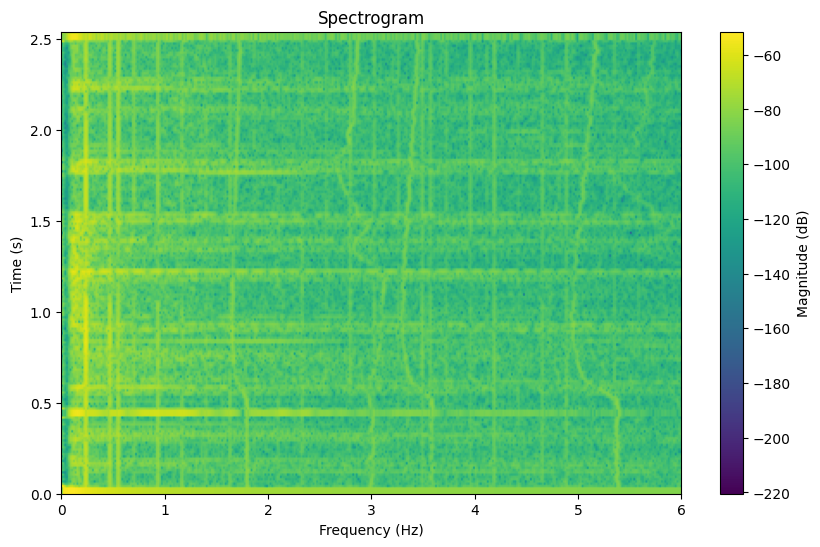

In [5]:
plt.figure(figsize=(10, 6))
plt.imshow(20 * np.log10(np.abs(sepctrogram_data)),  aspect='auto', origin='lower', extent=(0., fs/2, 0., sepctrogram_data.shape[0]/fs), cmap='viridis')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Time (s)')
plt.title('Spectrogram')
plt.colorbar(label='Magnitude (dB)')
plt.xlim(0, 6)
plt.show()